In [1]:
import torch
from matplotlib import pyplot as plt

from alfi.models import MultiOutputGP, generate_multioutput_rbf_gp
from alfi.configuration import VariationalConfiguration
from alfi.plot import Plotter1d
from alfi.utilities.torch import softplus
from alfi.impl.odes import RNAVelocityLFM

from dataset import SingleCellKidney, Pancreas
from trainer import EMTrainer

import numpy as np

In [2]:
# kidney_path = '/Volumes/ultra/genomics/scRNA-seq/GSE131685_RAW_kidney/velocyto'
# kidney_path = 'F:/genomics/scRNA-seq/GSE131685_RAW_kidney/velocyto'
#
# dataset = SingleCellKidney(calc_moments=True, raw_data_dir=kidney_path)
dataset = Pancreas()
print(dataset.m_observed.shape)
print(dataset.gene_names.shape)
print(dataset[0].shape)

torch.Size([1, 4000, 3696])
(2000,)
torch.Size([1, 3696])


In [3]:
def print_scatter(cells, gene_index, num_connections=10, colors=None):
    traj = trainer.previous_trajectory.mean.transpose(0, 1)
    u = traj[:2000].detach()  # (num_genes, 100)
    s = traj[2000:].detach()  # (num_genes, 100)
    u_y = cells[:2000]  # (num_genes, num_cells)
    s_y = cells[2000:]  # (num_genes, num_cells)

    plt.figure(figsize=(3, 3))
    plt.title(dataset.gene_names[gene_index])

    # Plot trajectory
    plt.plot(s[gene_index], u[gene_index], color='red')

    # Plot cell points
    indices = np.intersect1d(s_y[gene_index, :, 0].nonzero(),
                             u_y[gene_index, :, 0].nonzero())
    plt.scatter(s_y[gene_index, indices, 0], u_y[gene_index, indices, 0], alpha=0.1,s=5, c='black')

    # Plot timepoint choices
    for timepoint in range(trainer.timepoint_choices.shape[0]):
        plt.scatter(s[gene_index, timepoint], u[gene_index, timepoint], s=4, c='black')

    # Plot some connections between cell points and the trajectory line
    for i in range(num_connections):
        plt.scatter(s_y[gene_index, i, 0], u_y[gene_index, i, 0], s=8, c='red')
        line = [
            (s[gene_index, trainer.time_assignments_indices[i]], s_y[gene_index, i, 0]),
            (u[gene_index, trainer.time_assignments_indices[i]], u_y[gene_index, i, 0])
        ]
        plt.plot(line[0], line[1], alpha=0.5, c='purple')
        # trainer.time_assignments_indices[i]
    plt.ylabel('unspliced')
    plt.xlabel('spliced')

In [4]:
config = VariationalConfiguration(
    num_samples=30,
)
num_cells = dataset[0].shape[1]
num_latents = 10
num_inducing = 28  # (I x m x 1)

print('Number of cells:', num_cells)
print('Number of latent GPs (# transcription rates):', num_latents)

step_size = 1e-1

end_t = 12
inducing_points = torch.linspace(0, end_t, num_inducing).repeat(num_latents, 1).view(num_latents, num_inducing, 1)
t_predict = torch.linspace(0, end_t, 80, dtype=torch.float32)

gp_model = generate_multioutput_rbf_gp(num_latents, inducing_points,
                                       use_scale=False, initial_lengthscale=3,
                                       gp_kwargs=dict(natural=False))

Number of cells: 3696
Number of latent GPs (# transcription rates): 10


In [5]:
lfm = RNAVelocityLFM(num_cells, 4000, gp_model, config, nonlinearity=softplus)

optimizer = torch.optim.Adam(lfm.parameters(), lr=0.08)
trainer = EMTrainer(lfm, [optimizer], dataset, batch_size=4000)
plotter = Plotter1d(lfm, dataset.gene_names)

C:\Users\Jacob\Documents\proj\lafomo\alfi\models\variational_lfm.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.initial_conditions = Parameter(torch.tensor(torch.zeros(self.num_outputs, 1)), requires_grad=True)


torch.Size([362, 10])
torch.Size([362, 10])
torch.Size([3, 10, 362])
torch.Size([4000, 3696, 1])


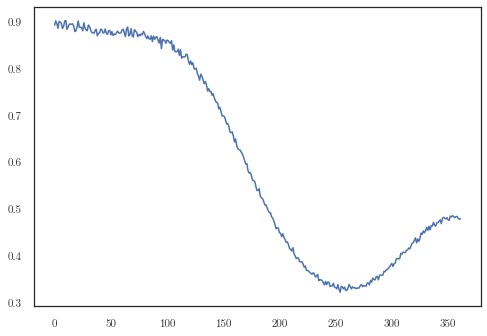

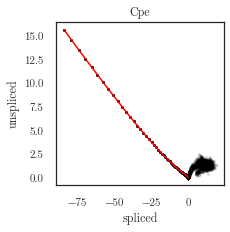

In [6]:
t = inducing_points
t_f = torch.arange(t.min(), t.max()+step_size/3, step_size/3)
# print('feeding gp with ', t_f.shape)
q_f = gp_model(t_f)
print(q_f.mean.shape)
s = lfm.sample_latents(t_f)[0]
print(s.shape)
plt.plot(s[:, 0].detach())

print(q_f.rsample(torch.Size([3])).permute(0, 2, 1).shape)
cpe_index = np.where(dataset.loom.var.index == 'Cpe')[0][0]
data = next(iter(trainer.data_loader))
cells = data.permute(0, 2, 1) # (O, C, 1)
print(cells.shape)
print_scatter(cells, cpe_index, num_connections=0)

tensor([0, 0, 0,  ..., 0, 0, 0])
tensor(False)
tensor(False)
torch.Size([10, 28])


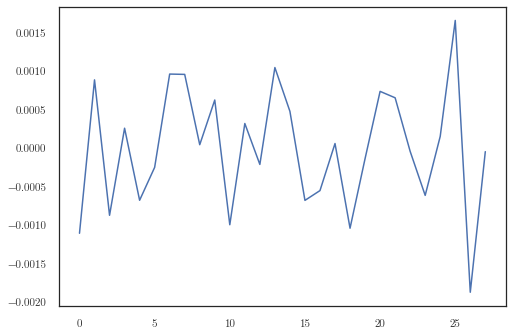

In [8]:
print(trainer.time_assignments_indices)
print(torch.isnan(lfm.splicing_rate).any())
print(torch.isnan(lfm.decay_rate).any())
mean = list(lfm.gp_model.variational_parameters())[0]
print(mean.shape)
plt.plot(mean.detach()[0])

In [ ]:
import time
start = time.time()

output = trainer.train(20, report_interval=1, step_size=1e-1)
end = time.time()
print(end - start)

estep done
num t: torch.Size([4])
torch.Size([4000, 3696]) torch.Size([4000, 3696])
covar torch.Size([4000, 3696, 3696])
torch.Size([4000, 3696]) MultivariateNormal(loc: torch.Size([4000, 3696]))
torch.Size([3696, 4000]) torch.Size([3696, 4000])
back
ward
Epoch 001/020 - Loss: 25347.70 (25347.70 0.00) kernel: [3.0761647 2.924138  2.924138  2.924138  3.0761647 2.924138  2.924138
 2.924138  2.924138  2.924138 ]
num t: torch.Size([4])
torch.Size([4000, 3696]) torch.Size([4000, 3696])
covar torch.Size([4000, 3696, 3696])
torch.Size([4000, 3696]) MultivariateNormal(loc: torch.Size([4000, 3696]))
torch.Size([3696, 4000]) torch.Size([3696, 4000])
back
ward
Epoch 002/020 - Loss: 24191.10 (24191.05 0.05) kernel: [3.0885572 2.878355  2.8810256 2.8916426 3.1353004 2.8528736 2.8818812
 2.9444435 2.8776226 2.862244 ]
num t: torch.Size([4])
torch.Size([4000, 3696]) torch.Size([4000, 3696])
covar torch.Size([4000, 3696, 3696])
torch.Size([4000, 3696]) MultivariateNormal(loc: torch.Size([4000, 3696]))

### Outputs prior to training:

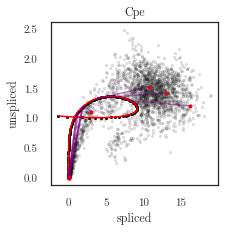

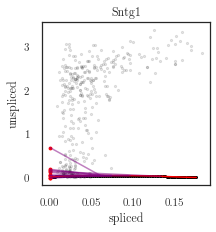

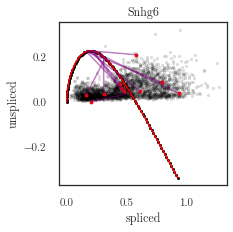

In [39]:
#0, -3 15
#0 -2 0 3
trainer.previous_trajectory = lfm(trainer.timepoint_choices, step_size=step_size)

# plotter.plot_outputs(t_predict, replicate=0, t_scatter=t_observed,y_scatter=dataset.m_observed, model_kwargs=model_kwargs);
# plotter.plot_latents(t_predict, ylim=(-1, 3), plot_barenco=True, plot_inducing=False)
data = next(iter(trainer.data_loader))
cells = data.permute(0, 2, 1) # (O, C, 1)

for i in [cpe_index] + list(range(0, 2)):
    print_scatter(cells, i)

In [29]:
# with torch.no_grad():
#     # lfm.splicing_rate[cpe_index] += 0.2
#     lfm.transcription_rate[cpe_index] += 0.5
print(lfm.decay_rate[cpe_index])
print(lfm.splicing_rate[cpe_index])
print(lfm.transcription_rate[cpe_index])

tensor([0.3868], dtype=torch.float64, grad_fn=<SelectBackward>)
tensor([0.9323], dtype=torch.float64, grad_fn=<SelectBackward>)
tensor([1.2626], dtype=torch.float64, grad_fn=<SelectBackward>)


torch.Size([4000, 3696])
torch.Size([100]) torch.Size([3696])
torch.Size([100, 4000])
False


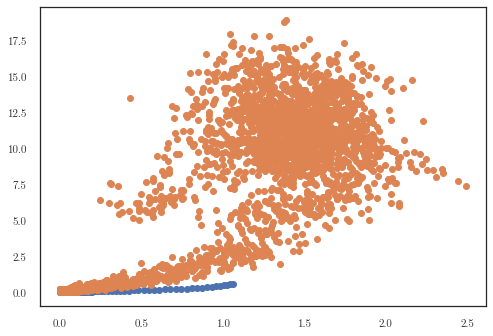

In [58]:
data = next(iter(trainer.data_loader))
y_target = data.permute(0, 2, 1).squeeze(-1)
print(y_target.shape)

u = trainer.previous_trajectory.mean[:, :2000].detach().t()[cpe_index]
s = trainer.previous_trajectory.mean[:, 2000:].detach().t()[cpe_index]
u_y = y_target[:2000][cpe_index]  # (num_genes, num_cells)
s_y = y_target[2000:][cpe_index]  # (num_genes, num_cells)
print(u.shape, u_y.shape)
plt.scatter(u, s)
plt.scatter(u_y, s_y)
print(trainer.previous_trajectory.mean.shape)
print(data.requires_grad)

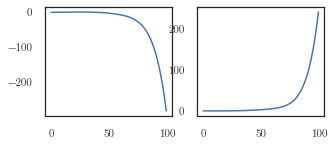

In [12]:
u = trainer.previous_trajectory.mean[:, :2000].detach()
s = trainer.previous_trajectory.mean[:, 2000:].detach()
fig, axes = plt.subplots(ncols=2, figsize=(5, 2))
axes[0].plot(u[:, cpe_index])
axes[1].plot(s[:, cpe_index])

In [13]:
n
import scvelo as scv
scv.tl.velocity(dataset.loom)

NameError: name 'n' is not defined

In [ ]:
scv.pl.velocity(dataset.loom, ['Cpe',  'Gnao1', 'Ins2', 'Adk'], ncols=2)

In [ ]:
velocity = dataset.loom.layers['velocity']
print(velocity[:100, cpe_index].shape)

data = next(iter(trainer.data_loader))
cells = data.permute(0, 2, 1) # (O, C, 1)
print(cells.shape)
print_scatter(cells, cpe_index, num_connections=0)



In [ ]:
lfm.gp_model.covar_module.lengthscale.shape

### Outputs after training

In [ ]:
plotter.plot_losses(trainer, last_x=100)
data = next(iter(trainer.data_loader))
cells = data.permute(0, 2, 1) # (O, C, 1)

for i in range(0, 50, 2):
    print_scatter(cells, i, num_connections=0)

torch.Size([2000, 3696, 1]) torch.Size([2000, 1, 100])
torch.Size([2000, 1000, 100])
torch.Size([1000, 100])
torch.Size([1000])
min torch.Size([1000])


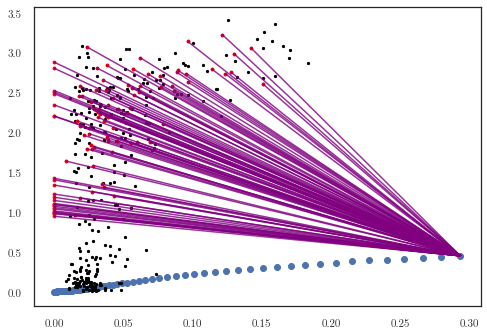

In [63]:
traj = trainer.previous_trajectory.mean.transpose(0, 1)
u = traj[:2000].detach().unsqueeze(2)  # (num_genes, 100, 1)
s = traj[2000:].detach().unsqueeze(2)  # (num_genes, 100, 1)
u_y = cells[:2000]  # (num_genes, num_cells)
s_y = cells[2000:]  # (num_genes, num_cells)
print(s_y.shape, s.transpose(1, 2).shape)
u_residual = u_y[:, :1000] - u.transpose(1, 2)
s_residual = s_y[:, :1000] - s.transpose(1, 2)
print(u_residual.shape) # (genes, cells, timepoints)
residual = u_residual.square() + s_residual.square()
# residual = residual.sum(dim=0).argmin(dim=1).type(torch.long)
gene_index = 0
residual = residual[gene_index]
print(residual.shape)
residual_indices = residual.argmin(dim=1)
print(residual_indices.shape)
residual_minimum = residual.min(dim=1).values
print('min', residual_minimum.shape)
residual_sort_indices = residual_minimum.argsort(descending=True)
# print(residual_sort_indices)
# for this gene, the indices of the closest timepoint for all cells

# Plot trajectory
plt.scatter(s[gene_index], u[gene_index])

# Plot cell points
indices = np.intersect1d(s_y[gene_index, :, 0].nonzero(),
                         u_y[gene_index, :, 0].nonzero())
plt.scatter(s_y[gene_index, indices, 0], u_y[gene_index, indices, 0], s=5, c='black')

for cell_index in residual_sort_indices[:100]:
    plt.scatter(s_y[gene_index, cell_index, 0], u_y[gene_index, cell_index, 0], s=8, c='red')
    line = [
    (s[gene_index, residual_indices[cell_index]], s_y[gene_index, cell_index, 0]),
    (u[gene_index, residual_indices[cell_index]], u_y[gene_index, cell_index, 0])
    ]
    plt.plot(line[0], line[1], alpha=0.8, c='purple')
# plt.xlim(0.015, 0.071)
# plt.ylim(0.22, 0.25)


In [ ]:
print(trainer.timepoint_choices[trainer.time_assignments_indices])
print(trainer.time_assignments_indices.shape)


In [ ]:
# plotter.plot_outputs(t_predict, replicate=0, ylim=(0, 3),
#                      t_scatter=t_observed, y_scatter=dataset.m_observed,
#                      model_kwargs=model_kwargs);
# plotter.plot_latents(t_predict, ylim=(-2, 4), plot_barenco=True, plot_inducing=False)
# plotter.plot_kinetics()
# plotter.plot_convergence(trainer)

In [ ]:
print(model.decay_rate)
print(model.transcription_rate)

In [ ]:
save(model, 'rnavelocity')

In [ ]:
do_load = False
if do_load:
    model = load('rnavelocity', RNAVelocityLFM, 2000, 1,
                 t_inducing, dataset, extra_points=2, fixed_variance=dataset.variance)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    trainer = EMTrainer(model, optimizer, dataset)
print(do_load)